In [1]:
"""
Programmer: Chris Tralie
Purpose: To create a collection of functions for making families of curves and applying
random rotations/translations/deformations/reparameterizations to existing curves
"""

import numpy as np
import matplotlib.pyplot as plt
import scipy.interpolate as interp
import sys


###################################################
#           TOPC Utility Functions                #
###################################################

def getRandomRigidTransformation(dim, std, special = False):
    """
    Generate a random rotation matrix and translation
    Parameters
    ---------
    dim: int
        Dimension of the embedding
    std: float
        Standard deviation of coordinates in embedding (used to help
        place a translation)
    
    Returns
    -------
    R: ndarray(dim, dim)
        Rotation matrix
    T: ndarray(dim)
        Translation vector
    """
    #Make a random rotation matrix
    R = np.random.randn(dim, dim)
    R, S, V = np.linalg.svd(R)
    if special and np.linalg.det(R) < 0:
        idx = np.arange(R.shape[0])
        idx[0] = 1
        idx[1] = 0
        R = R[idx, :]
    T = 5*std*np.random.randn(dim)
    return R, T

def applyRandomRigidTransformation(X, special = False):
    """
    Randomly rigidly rotate and translate a time-ordered point cloud
    Parameters
    ---------
    X: ndarray(N, dim)
        Matrix representing a time-ordered point cloud
    special: boolean
        Whether to restrict to the special orthogonal group
        (no flips; determinant 1)
    :return Y: Nxd matrix representing transformed version of X
    """
    dim = X.shape[1]
    CM = np.mean(X, 0)
    X = X - CM
    R, T = getRandomRigidTransformation(dim, np.std(X))
    return CM[None, :] + np.dot(X, R) + T[None, :]

def smoothCurve(X, Fac):
    """
    Use splines to smooth the curve
    :param X: Nxd matrix representing a time-ordered point cloud
    :param Fac: Smoothing factor
    :return Y: An (NxFac)xd matrix of a smoothed, upsampled point cloud
    """
    NPoints = X.shape[0]
    dim = X.shape[1]
    idx = range(NPoints)
    idxx = np.linspace(0, NPoints, NPoints*Fac)
    Y = np.zeros((NPoints*Fac, dim))
    NPointsOut = 0
    for ii in range(dim):
        Y[:, ii] = interp.spline(idx, X[:, ii], idxx)
        #Smooth with box filter
        y = (0.5/Fac)*np.convolve(Y[:, ii], np.ones(Fac*2), mode='same')
        Y[0:len(y), ii] = y
        NPointsOut = len(y)
    Y = Y[0:NPointsOut-1, :]
    Y = Y[2*Fac:-2*Fac, :]
    return Y

def makeRandomWalkCurve(res, NPoints, dim):
    """
    Make a random walk curve with "NPoints" in dimension "dim"
    :param res: An integer specifying the resolution of the random walk grid
    :param NPoints: Number of points in the curve
    :param dim: Dimension of the ambient Euclidean space of the curve
    :return X
    """
    #Enumerate all neighbors in hypercube via base 3 counting between [-1, 0, 1]
    Neighbs = np.zeros((3**dim, dim))
    Neighbs[0, :] = -np.ones((1, dim))
    idx = 1
    for ii in range(1, 3**dim):
        N = np.copy(Neighbs[idx-1, :])
        N[0] += 1
        for kk in range(dim):
            if N[kk] > 1:
                N[kk] = -1
                N[kk+1] += 1
        Neighbs[idx, :] = N
        idx += 1
    #Exclude the neighbor that's in the same place
    Neighbs = Neighbs[np.sum(np.abs(Neighbs), 1) > 0, :]

    #Pick a random starting point
    X = np.zeros((NPoints, dim))
    X[0, :] = np.random.choice(res, dim)

    #Trace out a random path
    for ii in range(1, NPoints):
        prev = np.copy(X[ii-1, :])
        N = np.tile(prev, (Neighbs.shape[0], 1)) + Neighbs
        #Pick a random next point that is in bounds
        idx = np.sum(N > 0, 1) + np.sum(N < res, 1)
        N = N[idx == 2*dim, :]
        X[ii, :] = N[np.random.choice(N.shape[0], 1), :]
    return X

###################################################
#               Curve Families                    #
###################################################

#Note: All function assume the parameterization is given
#in the interval [0, 1]


#######2D Curves
def getLissajousCurve(A, B, a, b, delta, pt):
    """
    Return the curve with
    x = Asin(at + delta)
    y = Bsin(bt)
    """
    N = len(pt)
    t = 2*np.pi*pt
    X = np.zeros((N, 2))
    X[:, 0] = A*np.sin(a*t + delta)
    X[:, 1] = B*np.sin(b*t)
    return X

def get2DFigure8(pt):
    """Return a figure 8 curve parameterized on [0, 1]"""
    return getLissajousCurve(1, 1, 1, 2, 0, pt)


def getPinchedCircle(pt):
    """Return a pinched circle paramterized on [0, 1]"""
    N = len(pt)
    t = 2*np.pi*pt
    X = np.zeros((N, 2))
    X[:, 0] = (1.5 + np.cos(2*t))*np.cos(t)
    X[:, 1] = (1.5 + np.cos(2*t))*np.sin(t)
    return X

def getEpicycloid(R, r, pt):
    N = len(pt)
    t = 2*np.pi*pt
    X = np.zeros((N, 2))
    X[:, 0] = (R+r)*np.cos(t) - r*np.cos(t*(R+r)/r)
    X[:, 1] = (R+r)*np.sin(t) - r*np.sin(t*(R+r)/r)
    return X

def getTschirnhausenCubic(a, pt):
    """
    Return the plane curve defined by the polar equation
    r = asec^3(theta/3)
    """
    N = len(pt)
    t = 5*(pt-0.5)
    X = np.zeros((N, 2))
    X[:, 0] = a*(1-3*t**2)
    X[:, 1] = a*t*(3-t**2)
    X = 2*X/np.max(np.abs(X))
    return X




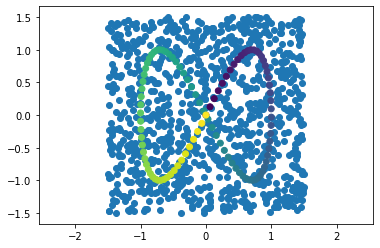

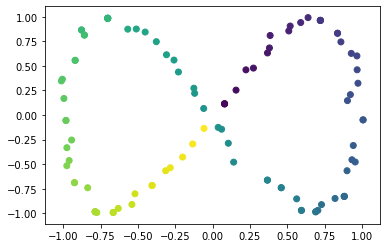

In [2]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Tue Jun 16 16:44:22 2020

@author: michaeltecce
"""

from SyntheticCurves import *
import numpy as np
import matplotlib.pyplot as plt

'''
state space S = space of all audio grain (blue dots)
(pi) array = array of initial costs
Y = observations array (ribbon)
'''

def getCSM(X, Y):
    """
    Return the cross-similarity matrix between two point-clouds;
    that is, a matrix whose ijth entry is the Euclidean distance
    between Xi and Yj
    Parameters
    ----------
    X: ndarray(M, d)
        First point cloud with M points in d dimensions
    Y: ndarray(N, d)
        Section point cloud with N points in d dimensions
    Returns
    -------
    C: ndarray(M, N)
        All pairs of distances from one to the next
    """
    C = np.sum(X**2, 1)[:, None] + np.sum(Y**2, 1)[None, :] - 2*X.dot(Y.T)
    C[C < 0] = 0
    return np.sqrt(C)

def calcP(S,K):
    P = np.zeros(S.shape[0])
    for i in range(0,K-1):
        P[i] = 1000
    P[np.random.randint(K-1)] = 0
    return P

def do_viterbi(S,Y,P):
    """
    Perform the Viterbi algorithm
    Parameters
    ---------
    S: ndarray(K, d)
        The possible states
    Y: ndarray(N, d)
        The observations
    P: ndarray(K)
        The starting state costs
    Returns
    -------
    X: ndarray(N, dtype=int)
        Indices of an optimal sequence of states
    """
    K = len(S)
    N = len(Y)
    T1 = np.ndarray(shape=(K,N), dtype=float)
    T2 = np.ndarray(shape=(K,N), dtype=float)
    A = getCSM(S, S)
    B = getCSM(S, Y)

    for i in range(K):
        T1[i,0] = P[i] + B[i,0]
        T2[i,0] = i
    for j in range(1,N):
        for i in range(K):
            T1[i,j] = np.min(T1[:,j-1]+A[:,i]+B[i,j])
            T2[i,j] = np.argmin(T1[:,j-1]+A[:,i]+B[i,j])
    
    X = np.zeros(N, dtype=int)
    X[N-1] = T2[K-1,N-1]
    a = X[N-1]
    for i in range(N-1,-1,-1):
        X[i] = T2[a,i]
        a = X[i]   
    
    return X

def do_2D_synthetic_test():
    """
    Do a test of Viterbi with a figure 8 with
    states in a square sampled around it
    """
    t = np.linspace(0, 1, 100)
    Y = get2DFigure8(t)
    np.random.seed(0)
    S = np.random.rand(1000, 2)
    S = S*3
    S[:, 0] -= 1.5
    S[:, 1] -= 1.5
    
    plt.scatter(S[:, 0], S[:, 1])
    plt.scatter(Y[:, 0], Y[:, 1], c = t)
    plt.axis('equal')
    plt.show()

    P = np.zeros(S.shape[0])
    #P = calcP(S,K)
    X = do_viterbi(S, Y, P)
    G = S[X, :]
    plt.scatter(G[:, 0], G[:, 1], c = np.arange(G.shape[0]))
    plt.show()

if __name__ == '__main__':
    do_2D_synthetic_test()


/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


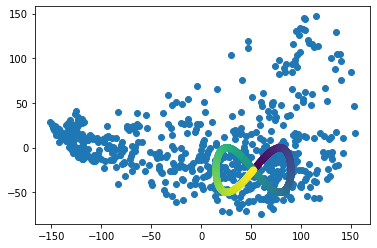

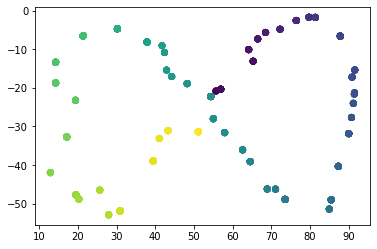

In [3]:
import librosa
import IPython.display as ipd # This is a library that allows us to play audio samples in Jupyter
from Viterbi import *
from sklearn.decomposition import PCA


if __name__ == '__main__':
    hop = 512
    x, sr = librosa.load("lincoln1.mp3")
    S = librosa.feature.mfcc(y=x, sr=sr, hop_length=hop, htk=True).T

    pca = PCA(n_components=2)
    S = pca.fit_transform(S)    
    
    t = np.linspace(0, 1, 1000)
    Y = get2DFigure8(t)
    
    Y = Y*25
    Y[:,0] += 35
    Y[:,0] *= 1.5
    Y[:,1] -= 25
    
    plt.scatter(S[:, 0], S[:, 1])
    plt.scatter(Y[:, 0], Y[:, 1], c = t)
    plt.show()
    
    
    P = np.zeros(S.shape[0])
    X = do_viterbi(S, Y, P)
    G = S[X, :]
    plt.scatter(G[:, 0], G[:, 1], c = np.arange(G.shape[0]))
    plt.show()
    
    
    

In [16]:
H = X*hop
SL = 500
PA = []
for i in range(0,len(H),1):
    for j in range(0,SL,1):
        q = x[H[i]+j]
        PA.append(q)


fs = 44100
ipd.Audio(PA, rate=fs)